## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/home/s12gb1/pytorchenv/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=d5aa931c-5ad1-4050-9377-d75fa96767a8
To: /home/s12gb1/thangdd/project_vqa/vqa_coco_dataset.zip
100%|████████████████████████████████████████| 196M/196M [00:07<00:00, 24.9MB/s]


In [4]:
!unzip -q vqa_coco_dataset.zip

## 1. Import libraries

In [6]:
!pip install timm spacy pandas matplotlib transformers -q

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

/home/s12gb1/anaconda3/envs/thangdd_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read dataset

In [2]:
train_data = []
train_set_path = 'datasets/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [3]:
val_data = []
val_set_path = 'datasets/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [4]:
test_data = []
test_set_path = 'datasets/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [5]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'yes', 1: 'no'}


## 3. Create Pytorch dataset

In [6]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        root_dir='datasets/val2014-resised/'
    ):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transforms:
            img = self.transforms(img)
        
        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}
            
        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question, 
                padding="max_length", 
                max_length=20, 
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)
            
        sample = {
            'image': img,
            'question': question,
            'label': label
        }
            
        return sample

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.4),
        #transforms.ElasticTransform(),
        transforms.GaussianBlur(3),
        #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        #transforms.RandomInvert()
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224))
    ]),
}

In [8]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['train']
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['val']
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['val']
)

In [9]:
train_batch_size = 512
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

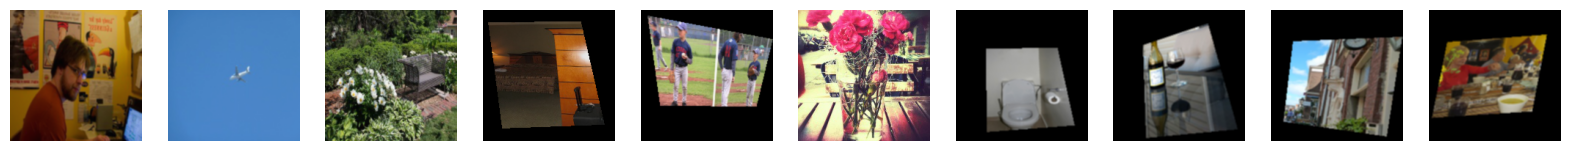

In [10]:
root_dir='datasets/val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(root_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transforms['train'](img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

# 5. Create Model

In [46]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [47]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [48]:
class Classifier(nn.Module):
    def __init__(
        self, 
        input_size=1024,
        hidden_size=512,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.classifer = nn.Linear(hidden_size, n_classes)
        
    def forward(self,x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.classifer(x)

        return x

In [49]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier
        self.visual_latent = nn.Linear(768, 1024)
        self.text_latent = nn.Linear(768, 1024)
        

    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)

        text_out = self.text_latent(text_out)
        image_out = self.visual_latent(image_out)
        x = text_out * image_out
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [51]:
n_classes = len(classes)
hidden_size = 256
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([512, 2])


## 6. Training

In [53]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [54]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        batch_train_losses = []

        train_correct = 0
        train_total = 0

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses, train_accs, val_accs

In [55]:
lr = 1e-2
epochs = 50
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses, train_accs, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.6926	Train acc: 0.5181	Val loss: 0.6920	Val acc: 0.5358606557377049


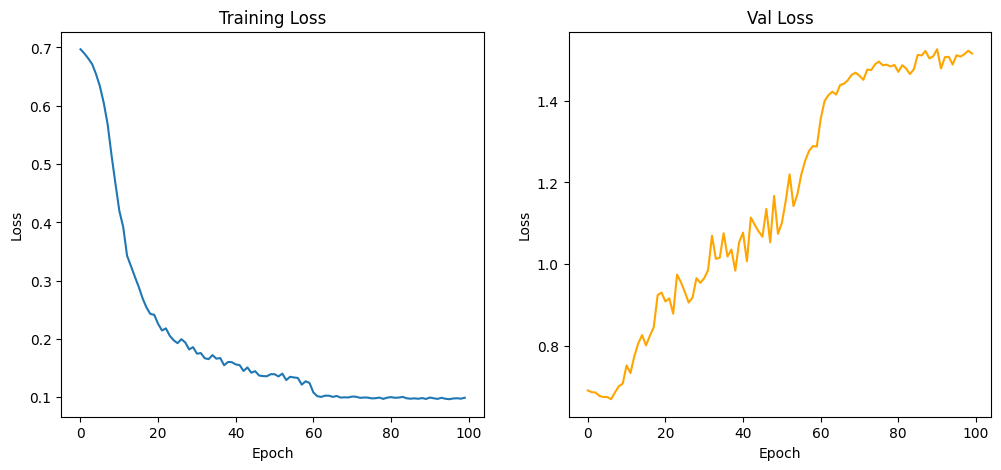

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [20]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7054303278688525
Test accuracy:  0.701780415430267
